Adapted from scikit-learn [plot_logistic_multinomial](https://scikit-learn.org/stable/auto_examples/linear_model/plot_logistic_multinomial.html),
with significant modifications (beyond just updating the color scheme...)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.datasets import make_blobs
from sklearn.linear_model import LogisticRegression

In [2]:
mcolors = np.array(['#00bbFF', '#FFbb00', '#00FF00']) #marker colors
colors = plt.rcParams['axes.prop_cycle'].by_key()['color'] #default colorcycle

from matplotlib.colors import LinearSegmentedColormap
bog = LinearSegmentedColormap.from_list('bog', colors[:3], 3) #blue|orange|green
#white -> blue, orange, green colormaps:
w_bog = [LinearSegmentedColormap.from_list(c,[(1,1,1),c]) for c in colors[:3]]

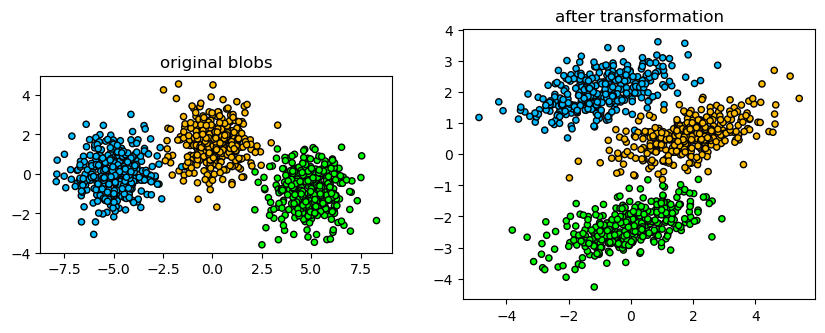

In [3]:
# make 3-class dataset for classification
centers = [[-5, 0], [0, 1.5], [5, -1]]
X, y = make_blobs(n_samples=1000, centers=centers, random_state=40)
#made 334 0s, 333 1s, 333 2s

plt.figure(figsize=(10,10))
plt.subplot(1,2,1)
plt.gca().set_aspect(1)
plt.scatter(*X.T, c=mcolors[y], ec='k', s=20);
plt.title('original blobs')

transformation = [[0.2, -0.4], [1.2, 0.4]] 
X = X @ transformation # stretches/squeezes and rotates blobs

plt.subplot(1,2,2)
plt.gca().set_aspect(1)
plt.scatter(*X.T, c=mcolors[y], ec='k', s=20)
plt.title('after transformation');

In [4]:
x_min,y_min = X.min(0)-1
x_max,y_max = X.max(0)+1
xg = np.arange(x_min, x_max, .02) #x grid
yg = np.arange(y_min, y_max, .02) #y grid
xmm = np.array([x_min, x_max])

xx,yy = np.meshgrid(xg,yg) # a grid of the x and y values
xy = np.transpose([xx,yy],(1,0,2)) #to calculate z values

def plot_decision_surface(): #define function since will use twice
    plt.contourf(xg, yg, Z, cmap=bog)
    plt.title(f"Decision surface of LogisticRegression ({mclass[m]})", fontsize=10)
    plt.axis('tight')
    plt.gca().set_aspect(1)
    plt.scatter(*X.T, c=mcolors[y], ec=edges, s=20) #training points
    # Plot the three one-against-all classifiers (arg of logit = 0)   
    for i, color in zip(clf.classes_, mcolors):
        yline = -(coeff[i,0]*xmm + intcpt[i])/coeff[i,1] #arg of logistic is 0
        plt.plot(xmm, yline, ls="--", color=color)

training score: 0.976 (ovr)
training score: 0.995 (multinomial)


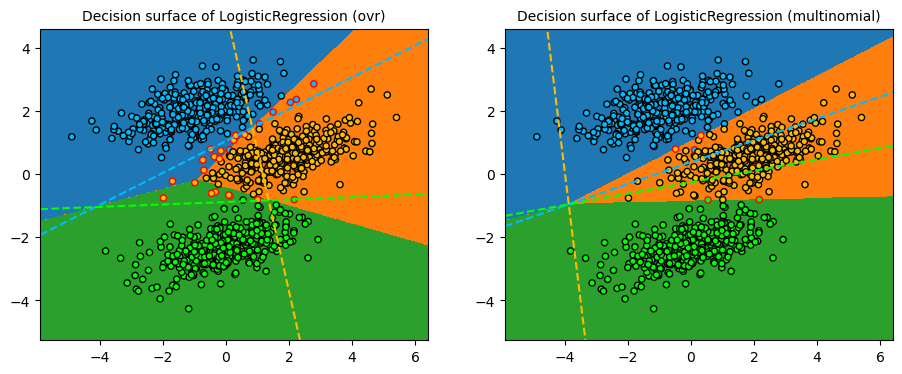

In [5]:
plt.figure(figsize=(11,11))
mclass = ('ovr', 'multinomial')
for m in range(2):
    clf = LogisticRegression(solver='sag', max_iter=100, random_state=42,
                             multi_class=mclass[m]).fit(X, y)
    print("training score: {:.3f} ({})".format(clf.score(X, y), mclass[m]))
    coeff, intcpt = (clf.coef_, clf.intercept_)
    edges = np.full(len(X), 'k')
    edges[clf.predict(X) != y] = 'r' # the ones wrong

    # decision boundary: assign color to each point in mesh
    # ravel is like .flatten, only 1000x faster, np.c_ stacks as two columns
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)    

    #save these results for later:
    if m==0: ovr_coeff,ovr_intcpt,Z_ovr, eco = (coeff, intcpt, Z, edges)
    else: multi_coeff,multi_intcpt,Z_multi, ecm = (coeff, intcpt, Z, edges)
    
    plt.subplot(1,2,m+1)
    plot_decision_surface()

Consider first the plot on the left above, showing the result for the ovr (=one vs rest) classifier.
The dotted lines indicate the .5 probability for the logistic classifier, i.e., indicate the best choice for dividing a class vs not in the class. So for example the blue dotted line is the best choice for dividing the blue from non-blue (i.e., green or orange) points, and similarly for the green dotted line.

Due to the nature of the data, the orange line does not fare as well: too much to the left and it inclues too many non-orange points, and too much to the right and it misses too many orange points. The classification boundaries are determined by which of the three ovr probabilities is largest at a given point on the plane, and the 24 misclassified points are indicated by red edges. These three lines are the best one can do using only the in-class vs out-of-class distinctions during training.

[The nature of these lines may be more evident in the plots below. The plots in the top line reproduce the two above, and the three plots lower plots in the left column show the logistic ovr probabilties for each of the blue, orange, and green classes separately. The fully saturated color means probability 1, and white means probability 0. The blue and green have narrow transitions, whereas the orange has a much wider uncertainty range, due the difficulty of accommodating the points in the central region.]

The plot on the right above shows the result of the multinomial logistic regression, which uses instead the labels for all three classes simultaneously to fit the decision boundaries, by taking the largest of the three probabilities at any point on the plane. Unlike the ovr, it is able to shift the orange dotted line to the left, giving higher orange likelihood to the previously misclassified points, because it can simultaneously move the blue green dotted lines closer together. The result is to extend the orange wedge to the left, correctly classifying most of the points missed by the ovr, but not misclassifying any additional points because the shifted blue and green lines make the wedge narrower. These coordinated changes now leave only 5 points misclassified.

In [6]:
def logit(x): return 1/ (1+np.exp(-x))

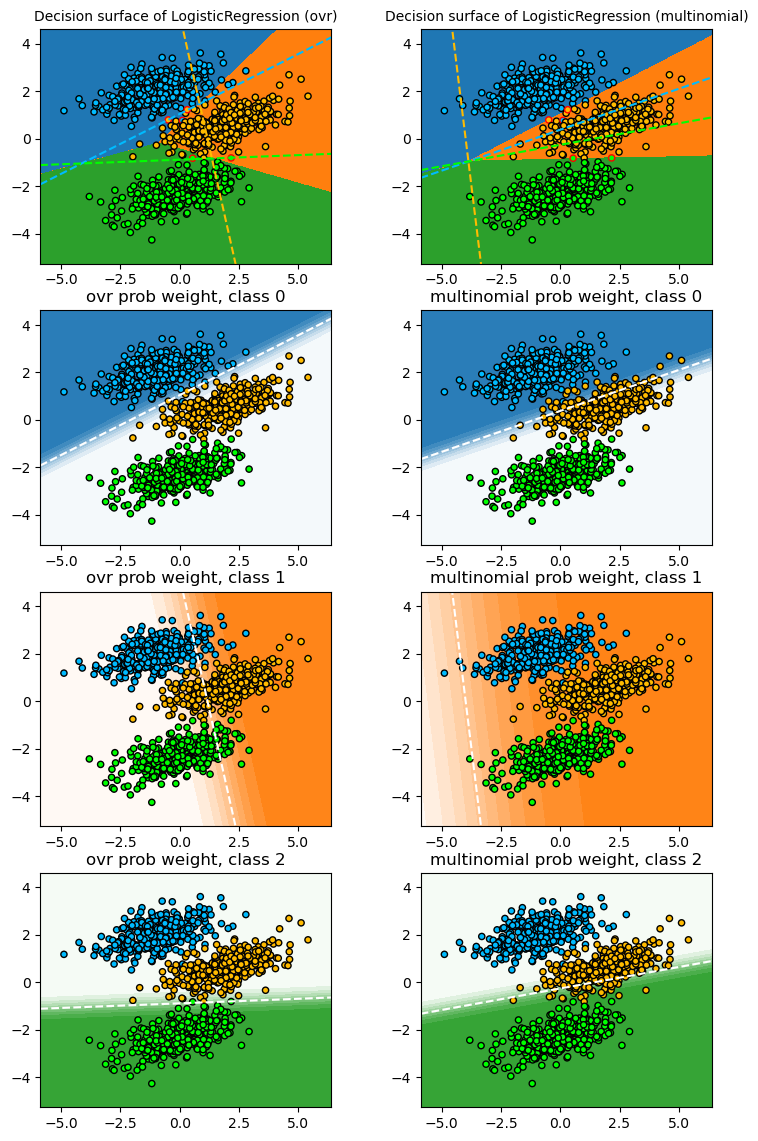

In [7]:
plt.figure(figsize=(9,14))
for m in range(2):
  if m==0: coeff,intcpt,Z = (ovr_coeff, ovr_intcpt, Z_ovr)
  else: coeff,intcpt,Z = (multi_coeff, multi_intcpt, Z_multi)
  zz = logit((coeff @ xy).transpose([1,0,2]) + intcpt[:,None,None])
  plt.subplot(4,2, m+1)
  plot_decision_surface()
    
  for i in range(3):
    plt.subplot(4,2, 2*i + m+3)
    plt.contourf(xg, yg, zz[i], levels=10, cmap=w_bog[i])
    plt.scatter(*X.T, c=mcolors[y], ec='k', s=20) #training points
    plt.axis('tight')
    plt.gca().set_aspect(1)
    
    yline = -(coeff[i,0]*xmm + intcpt[i])/ coeff[i,1]
    plt.plot(xmm, yline, ls="--", color= 'w') #mcolors[i])
    plt.title('{} prob weight, class {}'.format(mclass[m], i))

The plots above show the decision boundaries for each of the three classes independently.

The two plots below show them pieced together as in cell [5] above, but now with the most likely class probability function in each of the three decision regions.  The center region that had significant uncertainty for all three classes for the ovr classifier is replaced by the much higher likelihood of orange.

In [8]:
def triple_inter(coeff,intcpt):
    """simple algebra to find x value of intersection of two boundary lines"""
    numer = (intcpt[0]-intcpt[2]) / (coeff[0,1]-coeff[2,1])
    numer -= (intcpt[0]-intcpt[1]) / (coeff[0,1]-coeff[1,1])
    denom = (coeff[0,0] - coeff[1,0]) / (coeff[0,1]-coeff[1,1])
    denom -= (coeff[0,0] - coeff[2,0]) / (coeff[0,1]-coeff[2,1])
    return (numer / denom)

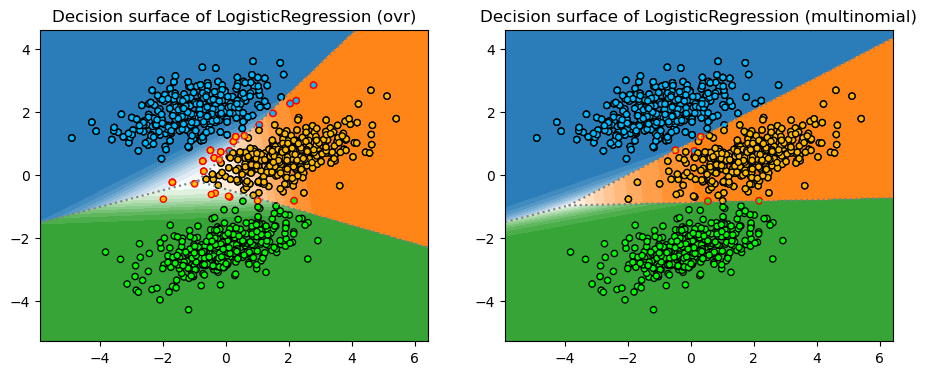

In [9]:
plt.figure(figsize=(11,10))
for m in range(2):
  plt.subplot(1,2,m+1)
  if m==0: coeff,intcpt,Z,edges = (ovr_coeff, ovr_intcpt, Z_ovr, eco)
  else: coeff,intcpt,Z,edges = (multi_coeff, multi_intcpt, Z_multi, ecm)
  zz = logit((coeff @ xy).transpose([1,0,2]) + intcpt[:,None,None])
  xti = triple_inter(coeff,intcpt)
  plt.title("Decision surface of LogisticRegression ({})".format(mclass[m]))

  for i in range(3):   
    mask = np.zeros_like(Z, dtype=bool)
    mask[Z!=i] = True
    plt.contourf(xg,yg, np.ma.array(zz[i], mask=mask), levels=10, cmap=w_bog[i])
    plt.scatter(*X.T, c=mcolors[y], ec=edges, s=20) #training points

#    yline = -(coeff[i,0]*xmm + intcpt[i])/coeff[i,1]  #the dotted lines now redundant
#    plt.plot(xmm, yline, ls="--", color=mcolors[i])
    
    j = (i+1)%3  #plot i vs j boundaries
    wij = coeff[i] - coeff[j]
    bij = intcpt[i] - intcpt[j]
    xtm = np.array([x_min,xti]) if wij[1] < 0 else np.array([xti, x_max])
    yline = -(wij[0]*xtm + bij)/ wij[1]
    plt.plot(xtm, yline, ls="dotted", color='grey')
    plt.axis([x_min,x_max,y_min,y_max])
    plt.gca().set_aspect(1)